In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime 
import datetime as dt

#os.getcwd()

Loading data:

In [3]:
# Patient data
patients=pd.read_csv('PATIENTS.csv')
#patients.info()

In [4]:
# Diagnosis ICD codes 
diag_icd=pd.read_csv('DIAGNOSES_ICD.csv')
diag_icd_rename=diag_icd.rename(columns={'ROW_ID':'DIAG_ICD_ROW_ID'})
#diag_icd_rename.info()

In [5]:
# Diagnosis Dictionary 
diag_dict=pd.read_csv('D_ICD_DIAGNOSES.csv')
diag_dict_rename=diag_dict.rename(columns={'ROW_ID':'DIAG_DICT_ROW_ID'})
#diag_dict_rename.info()

In [6]:
#Admission data
admission=pd.read_csv('ADMISSIONS.csv')
adm_rename=admission.rename(columns={'ROW_ID':'ADM_ROW_ID'})
#adm_rename.info()

In [7]:
#filtering the ICD by tuberculosis
diag_dict_filtered=diag_dict[diag_dict['LONG_TITLE'].str.contains("tuberculosis", case=False, na=False)]
#diag_dic_filtered.head()

# Join above df to Diagnosis dictionary data to ICD table to get pnt id
merged_icd=diag_dict_filtered.merge(diag_icd, on="ICD9_CODE", how ="inner")
#merged_icd.head()

merged_pnt_icd=patients.merge(merged_icd, on="SUBJECT_ID", how="inner")
#merged_pnt_icd.head()
#merged_pnt_icd.info()



In [8]:
merged_pnt_icd_adm=merged_pnt_icd.merge(adm_rename, on=['SUBJECT_ID','HADM_ID'], how="left")
#merged_pnt_icd_adm.info()

In [9]:
#calculating age at the time of admission
def pnt_admission_age(dob,admittime):
    birthdate=datetime.strptime(dob,"%Y-%m-%d %H:%M:%S")
    admitdt=datetime.strptime(admittime,"%Y-%m-%d %H:%M:%S")
    

    admit_age=(admitdt-birthdate).days//365
    return admit_age
merged_pnt_icd_adm["ADM_AGE"]=merged_pnt_icd_adm.apply(lambda row: pnt_admission_age(row["DOB"],row["ADMITTIME"]),axis=1)
#print(merged_pnt_icd_adm.head())


In [10]:
# define age bucket
bins = [0,2,4,12,19,39,59,70,80,100]
labels = ['Infants 0-1','Toddlers 2-4','Children 5-12','Teens 13-19','Adults 20-39','Mid Aged adults 40-59','Seniors 60 -70','Seniors 70 -80','Seniors 80+']

merged_pnt_icd_adm['AGE_GROUP']=pd.cut(merged_pnt_icd_adm['ADM_AGE'],bins=bins,labels=labels,right=False)
#print(merged_pnt_icd_adm.head())
#merged_pnt_icd_adm.info()

In [11]:
merged_pnt_icd_adm_unique=merged_pnt_icd_adm[['SUBJECT_ID','GENDER','ICD9_CODE','ADM_AGE','AGE_GROUP']].drop_duplicates()
#print(merged_pnt_icd_adm_unique.head())

/var/folders/8s/rjjqh8m12hggt98w3x81db0m0000gn/T/ipykernel_39147/411354743.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pnt_gender_count=merged_pnt_icd_adm.groupby(['AGE_GROUP','GENDER']).size().unstack(fill_value=0)


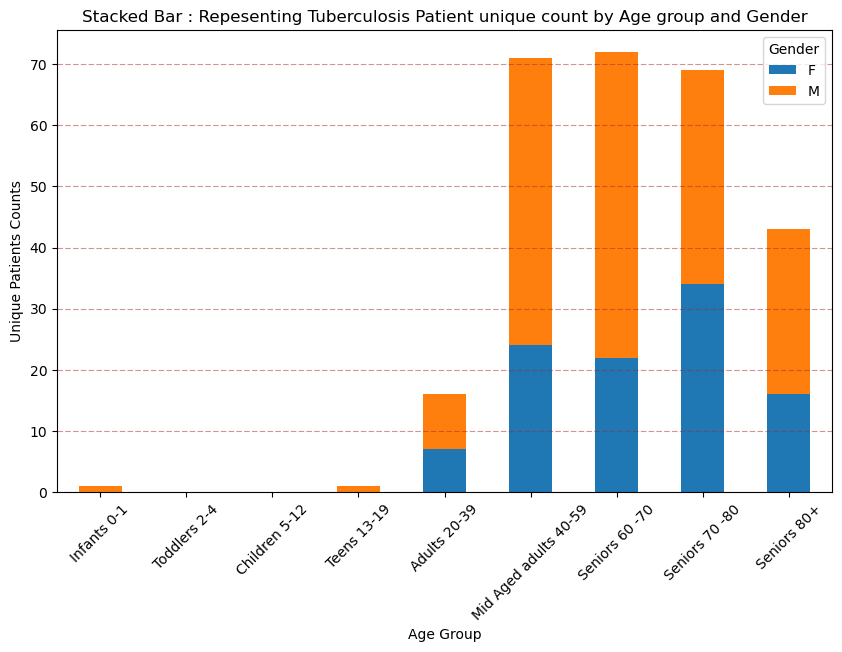

In [12]:
#stack bar by Age group & Gender

#count of pnts
pnt_gender_count=merged_pnt_icd_adm.groupby(['AGE_GROUP','GENDER']).size().unstack(fill_value=0)

stack_grp=pnt_gender_count.plot(kind='bar',stacked=True, figsize=(10,6))
plt.title("Stacked Bar : Repesenting Tuberculosis Patient unique count by Age group and Gender")
plt.xlabel("Age Group")
plt.ylabel("Unique Patients Counts")
plt.xticks(rotation=45)
plt.legend(title="Gender")

stack_grp.grid(axis='y',linestyle=(0,(5,2)), linewidth=0.8, alpha=0.5, color='brown')
#of pnts in each stach
#for i, AGE_GROUP in enumerate(pnt_gender_count.index):
 #   cumulative_height=np.zeros(len(pnt_gender_count.columns))
  #  for j, GENDER in enumerate(pnt_gender_count.columns):
   #     value=pnt_gender_count.loc[AGE_GROUP,GENDER]
    #    if value>0:
     #       stack_grp.text(i, cumulative_height[j]+value/2, str(value), ha='center',va='center')
      #  cumulative_height[j]+=value
plt.show()

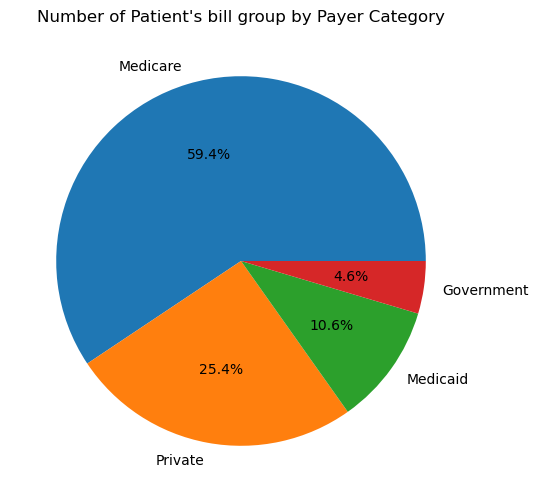

In [13]:
# Pie Graph : Number of Patient's bill group by Payer Category
merged_pnt_icd_adm_insurance=merged_pnt_icd_adm[['SUBJECT_ID','GENDER','INSURANCE']]
#print(merged_pnt_icd_adm_insurance)

payer_cnt=merged_pnt_icd_adm_insurance["INSURANCE"].value_counts()
#print(payer_cnt)

plt.figure(figsize=(6,6))
plt.pie(payer_cnt, labels=payer_cnt.index, autopct='%1.1f%%')
plt.title("Number of Patient's bill group by Payer Category")
plt.show()

In [14]:
admission["ADM_CNT"]=admission['ADMITTIME'].map(admission['ADMITTIME'].value_counts())
#print(admission.head())
#admission.info()

#plt.figure(figsize=(10,5))
#plt.plot(merged_pnt_icd_adm["ADMITTIME"],merged_pnt_icd_adm["ADM_CNT"],marker='o',linestyle='-',color='b',label="Admission count")
#plt.show()

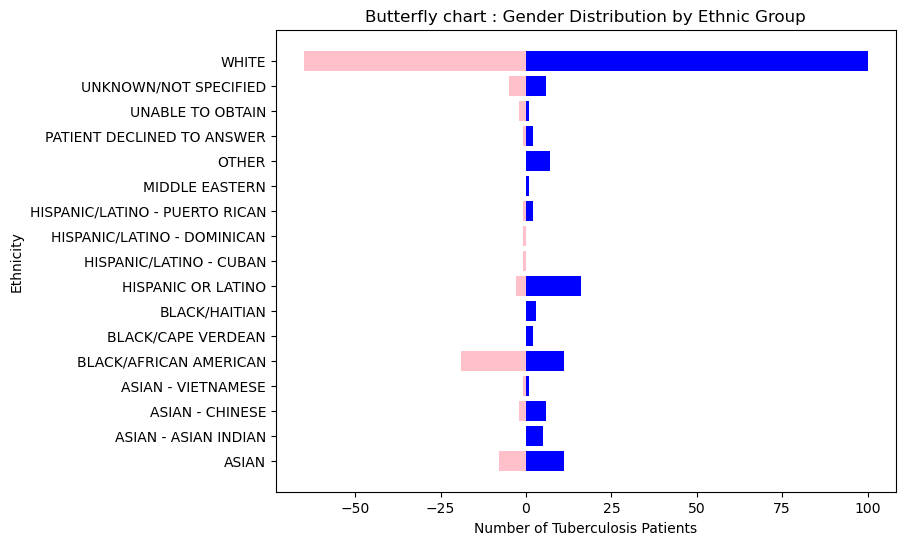

In [15]:

# Butterfly chart
#patients.info()
#adm_rename.info()

#count by gender and ethinicity

#merged_pnt_adms=patients.merge(admission, on=['SUBJECT_ID'], how="left")
#merged_pnt_adms.info()

merged_pnt_adms_req_column=merged_pnt_icd_adm[['SUBJECT_ID','GENDER','ETHNICITY']]
#merged_pnt_adms_req_column.info()

eth_count=merged_pnt_adms_req_column.groupby(["ETHNICITY","GENDER"]).size().unstack(fill_value=0)
#eth_count.info()
#print(eth_count)

ethcty=eth_count.index
male_cnt=eth_count["M"]
female_cnt=eth_count["F"] *-1

fig,ax=plt.subplots(figsize=(8,6))
ax.barh(ethcty, male_cnt,color="blue",label="MALE")
ax.barh(ethcty, female_cnt,color="pink",label="FEMALE")

ax.set_xlabel("Number of Tuberculosis Patients")
ax.set_ylabel("Ethnicity")
ax.set_title("Butterfly chart : Gender Distribution by Ethnic Group")

plt.show()


In [16]:
'''
merged_pnt_icd_adm['ADMITDATE']=merged_pnt_icd_adm['ADMITTIME'].dt.date
merged_pnt_icd_adm.info()
#merged_pnt_icd_adm["ADM_CNT"]=merged_pnt_icd_adm['ADMITTIME'].map(merged_pnt_icd_adm['ADMITTIME'].value_counts())
print(merged_pnt_icd_adm)
#merged_pnt_icd_adm.info()

plt.figure(figsize=(10,5))
plt.plot(merged_pnt_icd_adm["ADMITTIME"],merged_pnt_icd_adm["ADM_CNT"],marker='o',linestyle='-',color='b',label="Admission count")
plt.show()
'''

'\nmerged_pnt_icd_adm[\'ADMITDATE\']=merged_pnt_icd_adm[\'ADMITTIME\'].dt.date\nmerged_pnt_icd_adm.info()\n#merged_pnt_icd_adm["ADM_CNT"]=merged_pnt_icd_adm[\'ADMITTIME\'].map(merged_pnt_icd_adm[\'ADMITTIME\'].value_counts())\nprint(merged_pnt_icd_adm)\n#merged_pnt_icd_adm.info()\n\nplt.figure(figsize=(10,5))\nplt.plot(merged_pnt_icd_adm["ADMITTIME"],merged_pnt_icd_adm["ADM_CNT"],marker=\'o\',linestyle=\'-\',color=\'b\',label="Admission count")\nplt.show()\n'

Text(0.5, 1.0, 'TAT - Turn Around Time between time of admission and Discharge date for Tuberculosis Patients ')

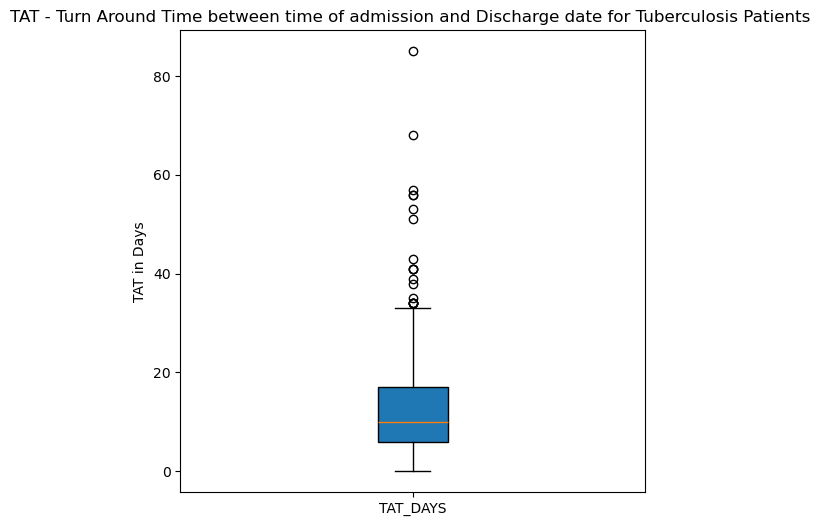

In [17]:
#TAT - Turn Around Time between time of admission and Discharge date 
def pnt_admission_tat(adtime,dstime):
    adt=datetime.strptime(adtime,"%Y-%m-%d %H:%M:%S")
    dst=datetime.strptime(dstime,"%Y-%m-%d %H:%M:%S")
    

    tat=(dst-adt)
    return tat
merged_pnt_icd_adm["TAT"]=merged_pnt_icd_adm.apply(lambda row: pnt_admission_tat(row["ADMITTIME"],row["DISCHTIME"]),axis=1)
merged_pnt_icd_adm["TAT_DAYS"]=merged_pnt_icd_adm["TAT"].dt.days
#print(merged_pnt_icd_adm.head())

plt.figure(figsize=(6,6))
plt.boxplot(merged_pnt_icd_adm["TAT_DAYS"],vert=True,patch_artist=True)

plt.xticks([1],["TAT_DAYS"])
plt.ylabel("TAT in Days")
plt.title("TAT - Turn Around Time between time of admission and Discharge date for Tuberculosis Patients ")



          Admission location  count
0       EMERGENCY ROOM ADMIT     96
1  PHYS REFERRAL/NORMAL DELI     74
2  CLINIC REFERRAL/PREMATURE     72
3  TRANSFER FROM HOSP/EXTRAM     38
4  TRANSFER FROM SKILLED NUR      2
5  TRANSFER FROM OTHER HEALT      1


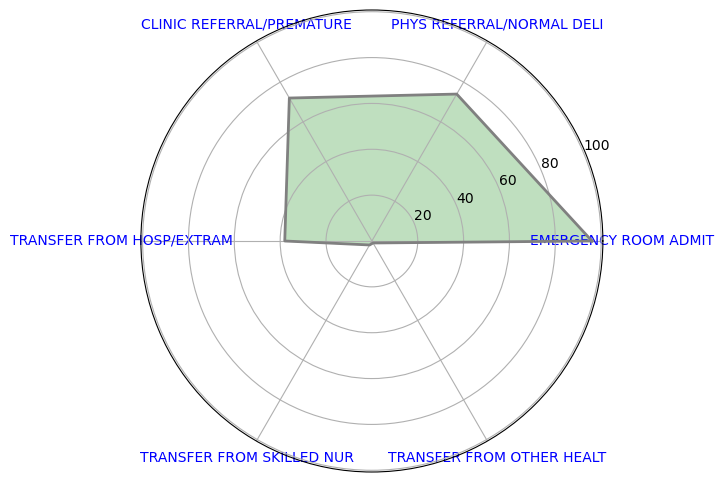

In [80]:
# Radar Graph: Number of Patient's admission by location 
amd_loct=merged_pnt_icd_adm['ADMISSION_LOCATION'].value_counts().reset_index()
amd_loct.columns=["Admission location","count"]
print(amd_loct)

category=amd_loct["Admission location"].astype(str).tolist()
values=amd_loct["count"].tolist()
num_vars=len(category)
#print(num_vars)

angles=np.linspace(0,2 * np.pi,num_vars, endpoint=False) .tolist()
#values =values.tolist()
values +=values[:1]
angles +=angles[:1]

fig,ax=plt.subplots(figsize=(6,6),subplot_kw=dict(polar=True))
ax.fill(angles, values,color='green', alpha=0.25)
ax.plot(angles, values, color='grey', linewidth=2)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(category,color='b')
plt.show()

    Admission year  count
0             2161     10
1             2158      8
2             2138      8
3             2173      8
4             2169      7
..             ...    ...
89            2171      1
90            2100      1
91            2109      1
92            2184      1
93            2106      1

[94 rows x 2 columns]


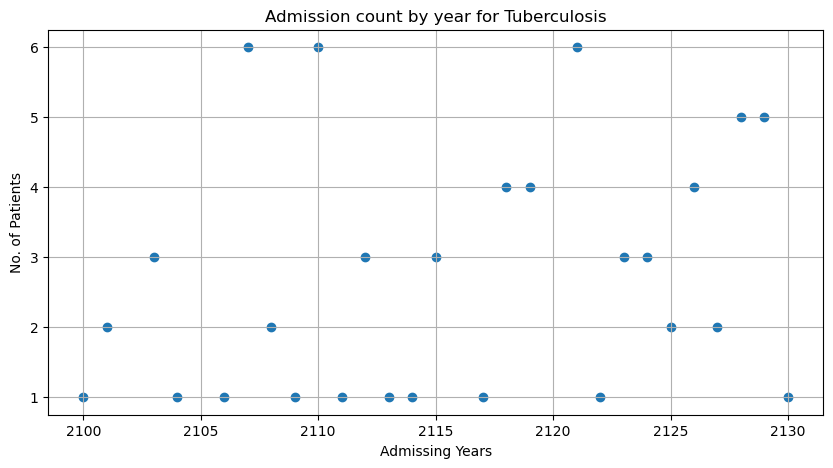

In [174]:
# Admission count by year

merged_pnt_icd_adm["adtime"]=pd.to_datetime(merged_pnt_icd_adm["ADMITTIME"])
merged_pnt_icd_adm["adt_year"]=merged_pnt_icd_adm["adtime"].dt.year
#print(merged_pnt_icd_adm.head())


amd_cnt_year=merged_pnt_icd_adm['adt_year'].value_counts().reset_index()
amd_cnt_year.columns=["Admission year","count"]
print(amd_cnt_year)

st_year= 2100
end_year=2130
filter_year_df=amd_cnt_year[(amd_cnt_year["Admission year"]>= st_year)& (amd_cnt_year["Admission year" ] <= end_year)]
plt.figure(figsize=(10,5))
plt.scatter(filter_year_df["Admission year"],filter_year_df["count"], marker="o")

plt.xlabel("Admissing Years")
plt.ylabel("No. of Patients")
plt.title("Admission count by year for Tuberculosis")
plt.grid(True)
plt.show()